In [240]:
from sklearn.datasets import fetch_openml
import pandas as pd
import matplotlib as mpl
import numpy as np
import  matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_recall_curve, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# This would have been a way to import the MNIST Data from Scikit-learn but my network was poor wich i then downloaded
mnist = fetch_openml('mnist_784', version=1)

In [ ]:
mnist.keys()

The MNIST data contains 70,000 features and 784 labels

In [ ]:
X, y = mnist['data'], mnist['target']

print(X.shape)
print(y.shape)

In [ ]:
# Show an image
some_digits = X[0:1]
some_digits = np.array(some_digits, dtype='float')
some_digits_image = some_digits.reshape(28,28)

plt.imshow(some_digits_image, cmap=mpl.cm.binary, interpolation='antialiased') #other form of interpolation to generate pixel are: 'nearest', 'bicubic', 'bilinear' Check out the Documentation to understand more 
plt.axis('on')
plt.show()

In [ ]:
# Convert y to int so that we can be able to use it
y = y.astype(np.uint8)
y.info()

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [ ]:
# Check if my Set's are Bias
ydf = np.array(y_train, dtype="int")
ydft = np.array(y_test, dtype="int")
y_train_bias_5 = print(f"Size of row in train set: {len(ydf)}\nThis is the sum of 5 in the train set: {sum(ydf==5)}\nThis is the sum of 5 that are not 5 in the train set: {sum(ydf!=5)}")
y_test_bias_show = print(f"Size of row in test set: {len(ydft)}\nThis is the sum of 5 in the test set: {sum(ydft==5)}\nThis is the sum of 5 that are not 5 in the test set: {sum(ydft!=5)}")
y_train_5 = y_train == 5
y_test_5 = y_test == 5

In [ ]:
sdf_clf = SGDClassifier(random_state=42)
sdf_clf_fit = sdf_clf.fit(X_train, y_train_5)

y_pred = sdf_clf_fit.predict(some_digits)

In [169]:
cross_score = cross_val_score(sdf_clf, X_train, y_train_5,cv=3, scoring="accuracy") # K-folds cross validation means spliting the training set into k-folds(in this case, 5), then making prediction and evaluating them on each fold using model a model trained on the remaining folds. It reture the evaluation score

In [172]:
y_train_pred = cross_val_predict(sdf_clf, X_train,y_train_5, cv=3) # returns the predictions made on each test fold

In [175]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

53892 = True Negative(TN)
687 = False Positive(FP)
1891 = False Negative(FN)
3530 = True Positive(TP)
For a perfect model our wrongly predicted value(i.e: FP and FN) should be 0. We could also try using the Precision, Recall, and F1_score
## Mathematically 
*Precision* = TP/(TP + FP)
*Recall* = TP/(TP + FN)
*F1_score* = 2 × (precision × recall)/(precision + recall)



In [177]:
y_scores = cross_val_predict(sdf_clf, X_train, y_train_5, cv=3, method="decision_function")

In [178]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [181]:
precision, recall, threshold = precision_recall_curve(y_train_5, y_scores)

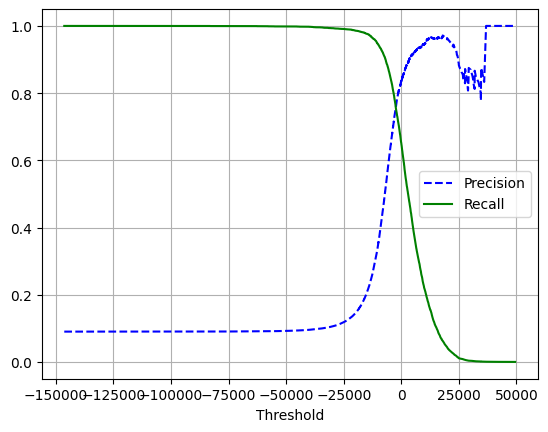

In [214]:
def plot_precision_recall_vs_threshold(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], 'b--', label = "Precision")
    plt.plot(threshold, recall[:-1], "-g", label="Recall")
    plt.xlabel("Threshold")
    plt.autoscale()
    plt.grid(visible=True)
    plt.legend()
    
plot_precision_recall_vs_threshold(precision,recall, threshold)
plt.show()

From the plot: why the precision plot is bumpier is because Precision tends to go down when you increase the threshold. On the other hand, recall can only go down when the thres‐
hold is increased, which explains why its curve looks smooth 

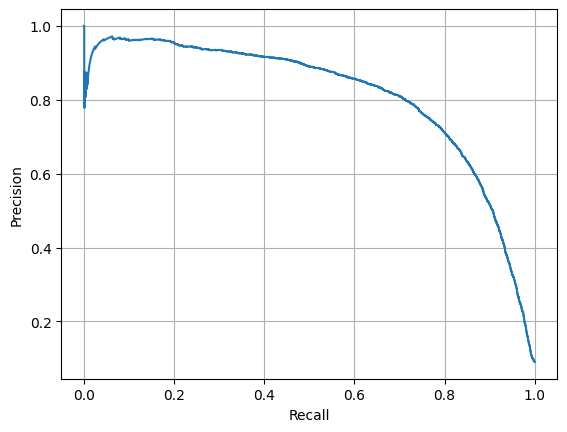

In [217]:
plt.plot(recall,precision,scalex=True)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.grid(visible=True)

Supposedly we are looking for 95% precision from our model we will use the following

In [218]:
threshold_95_precision = threshold[np.argmax(precision >= 0.95)]

In [222]:
y_train_pred_95 = (y_scores >= threshold_95_precision)

In [228]:
precision_score(y_train_5, y_train_pred_95) # Now we've acheived a 95% precision score for our model

0.9503367003367004

In [230]:
recall_score(y_train_5, y_train_pred_95) # Note that our recall score is very poor with 20.8% score. Which quantify this 'A high-precision classifier is not very useful if its recall is too low'

0.20826415790444566

# ROC Curve And ROC AUC 

In [235]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [237]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr,tpr, label=label)
    plt.plot([0,1], [0,1], 'b--')
    plt.legend()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate(Recall)")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


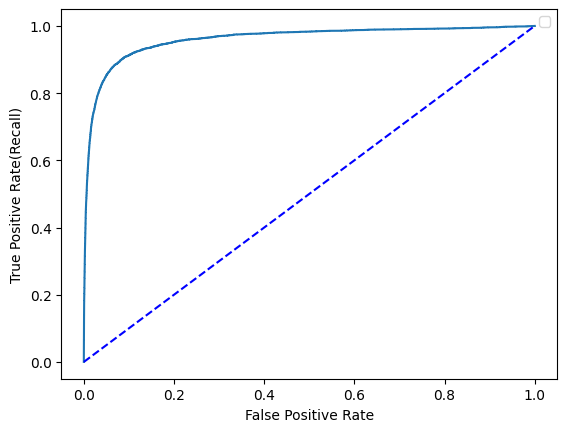

In [238]:
plot_roc_curve(fpr,tpr)

In [239]:
roc_auc_score(y_train_5,y_scores)

0.9604938554008616

When do will Decide when to use precision/recall curve or AUC Curve is whenever the positive class is rare or when you care more about the false positives than the false negatives, and the ROC curve otherwise

*Let's try and train a new model and compare both the ruc cuve with the old model*

In [ ]:
forest_clf = RandomForestClassifier(random_state=42)

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, method='predict_proba')

In [ ]:
y_probas_forest